In [ ]:
%load_ext autoreload
%autoreload 2
from context import *

# Correlations

The notion of correlation is present in most of data analysis projects.
A correlation between two variables means that those two variables have a tendency to behave in a similar way.
There are many definitions of "behaving in a similar way", which lead to various tools.
We will present the two most popular definitions of correlation and their behaviour on complex data.

Correlation is a tool to summarize how two variables interact.
Different correlation techniques assume some properties on the data, and then compute how related they are under those assumptions.
As a result, the level of correlation may be far from the underlying relation if the data does not fit the assumptions.
Like most tools presented in this course, the analyst must be cautious on wether the data have the correct properties to use a specific algorithm.

Correlation is used in many situations where one wishes to identify tightly related variables.
In many instances, it is counter productive to consider multiple variables which contain basically the same information.
Then correlation can be used to identify those.

To get the dataset under study, you can run the following pipeline. 
No external data is required as this dataset is natively present in `scikit-learn`.
`python -m src.data.cancer`

In [ ]:
raw = pd.read_parquet(INTDIR / "breast_cancer.parquet")
print(raw.shape)
raw.head()

(569, 31)


mean_radius  mean_texture  mean_perimeter  mean_area  mean_smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean_compactness  mean_concavity  mean_concave_points  mean_symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean_fractal_dimension  ...  worst_texture  worst_perimeter  worst_area  \
0                 0.07871  ...          17.33           184.60      2019.0   
1                 0.05667  ...          23.41           158.80      1956.0   
2                 0.05999  ...          25.53           152.50      1709.0   
3                 0.09744  ...          26.50            98.87       567.7   
4                 0.05883  ...          16.67           152.20      1575.0   

   worst_smoothness  worst_compactness  worst_concavity  worst_concave_points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   worst_symmetry  worst_fractal_dimension  target  
0          0.4601                  0.11890       0  
1          0.2750                  0.08902       0  
2          0.3613                  0.08758       0  
3          0.6638                  0.17300       0  
4          0.2364                  0.07678       0  

[5 rows x 31 columns]

The [breast cancer dataset](https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset) is a well known dataset in wich experts have measured tumor properties thanks to images.
This was way before modern capabilities of computer vision.
It contains about thirty measurements for 569 tumors, which can be malign (`target=1`) or benign (`target=0`).

Among the properties, we have two interesting variables : `mean_radius`, `mean_perimeter`.
Those variables are interesting because they are expected to be highly related.
Indeed, with spherical-like tumors, we expect a relation like $perimeter = 2\pi radius$.
When we graph these two variables, we see indeed a linear relation between them.
We expect a large correlation of those two variables.

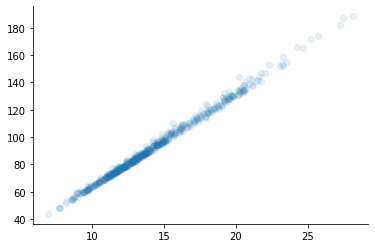

In [ ]:
plt.scatter(raw["mean_radius"], raw["mean_perimeter"], alpha=0.1);

If we look instead at the relation between `mean_radius` and `mean_smoothness` we observe no obvious relation between them.
Knowing one of the variables does not give us any indication on the probable value of the other.

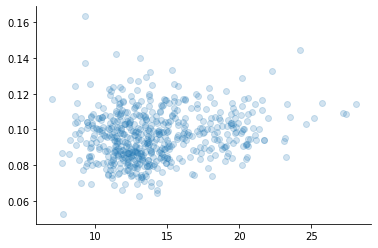

In [ ]:
plt.scatter(raw["mean_radius"], raw["mean_smoothness"], alpha=0.2);

Sometimes, variables may have a strong non linear relation.
Here we consider non linear transformations of the `mean_perimeter` column, and we compare them to the `mean_radius`.
With those two transformations there remains a strong relation between the variables, but there is no straight line anymore.

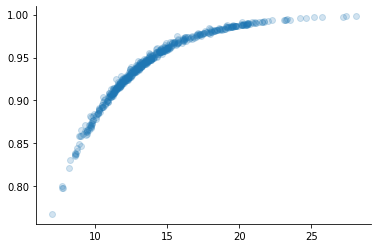

In [ ]:
raw["exp_perimeter"] = 1 - np.exp(-raw["mean_perimeter"] / 30)
plt.scatter(raw["mean_radius"], raw["exp_perimeter"], alpha=0.2);

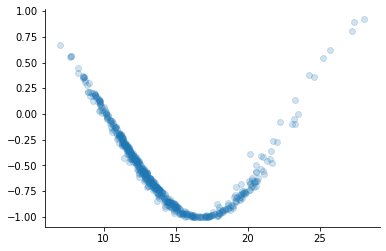

In [ ]:
raw["cos_perimeter"] = np.cos((raw["mean_perimeter"] - 20) / 180 * 2 * np.pi)
plt.scatter(raw["mean_radius"], raw["cos_perimeter"], alpha=0.2);

It is not always practical to plot all possible scatter plots.
With a large dataset this becomes too much for a single person to inspect individually.

Then, **how can we phrase our intuition into a mathematical form?**

## Pearson correlation

Pearson correlation is one of the oldest notion of correlation.
It can be expressed in the following way : there exists a correlation between two variables if there is a tendency for these variables to be above their mean at the same time.
Mathematically, it is expressed with the following formula.

$$r = \frac{ \sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y}) }{%
        \sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}$$
        
The numerator is positive if both variables are on the same side of their mean and negative otherwise.
If the variables are totally independent of each other, negatives and positives should compensate on average and give a value around 0.
If both variables have a tendency to be on the same side, the numerator will be a large positive number.
If both variables have a tendency to be on opposite sides, the numerator will be a large negative number.
The denominator limits $r$ between $-1$ if variables have perfect opposite behaviour, and $+1$ if they behave identically. 

Let's look at some examples.

The [`pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) function in the `scipy` library provides the implementation for the Pearson correlation coefficient.
This function returns a tuple.
The correlation coeficient we are interested in is the first element.

In [ ]:
from scipy.stats import pearsonr

In [ ]:
# A variable correlation with itself is one
pearsonr(np.arange(50), np.arange(50))[0]

1.0

In [ ]:
# A variable correlation with negative itself is -1
pearsonr(np.arange(50), -np.arange(50))[0]

-1.0

In [ ]:
# A variable correlation with an affine transformation of itself is 1
pearsonr(np.arange(50), 2 + 5 * np.arange(50))[0]

1.0

In [ ]:
# However applying to a non linear transformation of the initial variable
# changes drastically the results
pearsonr(np.arange(50), np.exp(np.arange(50)))[0]

0.35251621046921966

We see that the correlation between a variable and a non linear transformed version of itself is much lower.
This is because the pearson correlation expects each variable to be related along a straight line.
When applying the exponential function to our test example, this linear assumption does not stand anymore.
As a result, the actual correlation value strongly depends on how far is the transformation from a linear one.
Then the correlation value may take any arbitrary value; it looses its meaning.
The analyst must then always keep in mind that the Pearson correlation value is meaningful only under some circonstances.

To better understand why the correlation changes that much, lets compute the number of elements above the mean.
With a simple variable containing number between 0 and 49 the mean corresponds to the median, and half the points are above it.
When performing the same study on the exponential transformation, we see that the mean has severly increased, but also that we have only 4 remaining points above the average.
A closer look at the values of those points shows that the last ones have much larger values than the first ones (because of the exponential).
Hence the mean is dramatically shifted toward large values, and only a couple of points are above it.

In [ ]:
def count_above_mean(x):
    m = x.mean()
    print("mean : ", m)
    print("above mean", x[x > m].shape)

In [ ]:
count_above_mean(np.arange(50))

mean :  24.5
above mean (25,)


In [ ]:
count_above_mean(np.exp(np.arange(50)))

mean :  6.034755699228589e+19
above mean (4,)


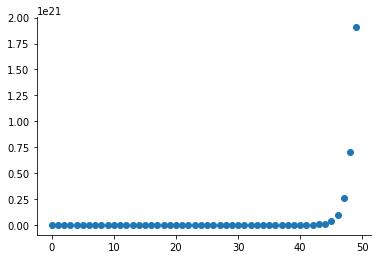

In [ ]:
plt.scatter(np.arange(50), np.exp(np.arange(50)));

Now that we have seen a toy example, let's go back to our `mean_radius` and `mean_perimeter` variables.
We have seen earlier that their scatter plot is an almost perfect line.
The Pearson correlation will have an almost perfect value of $1$ in this situation.

In [ ]:
pearsonr(raw["mean_radius"], raw["mean_perimeter"])[0]

0.9978552814938108

Inversely, `mean_radius` and `mean_smoothness` have a much lower Pearson correlation; which corresponds to the lack of relation observed in the graph.

In [ ]:
pearsonr(raw["mean_radius"], raw["mean_smoothness"])[0]

0.17058118749299475

With an exponential transformation of the perimeter, we saw a remaining strong relation with `mean_radius`.
The resulting scatter plot is not a straight line; but is not too far from it.
Then the correlation is still high between the two variables.

In [ ]:
pearsonr(raw["mean_radius"], raw["exp_perimeter"])[0]

0.8973477786238652

The cosine transformation is more radical in term of non linearity.
Again we see on the scatter plot a line; but which has a complex form.
We are here in an extreme case where the Pearson assumption clearly does not stand anymore.
The correlation then gets an extremely different value.

In [ ]:
pearsonr(raw["mean_radius"], raw["cos_perimeter"])[0]

-0.43033876451949604

Finally the `corr` function of pandas allows us to compute in a single go the correlation values between all pairs of columns in a `DataFrame`.
Selecting a single columns then allows to get the correlation of this column with all the remaining ones.

In [ ]:
c = raw[
    [
        "mean_radius",
        "mean_perimeter",
        "mean_smoothness",
        "exp_perimeter",
        "cos_perimeter",
    ]
].corr()
c

mean_radius  mean_perimeter  mean_smoothness  exp_perimeter  \
mean_radius         1.000000        0.997855         0.170581       0.897348   
mean_perimeter      0.997855        1.000000         0.207278       0.893904   
mean_smoothness     0.170581        0.207278         1.000000       0.140049   
exp_perimeter       0.897348        0.893904         0.140049       1.000000   
cos_perimeter      -0.430339       -0.420607        -0.002714      -0.745344   

                 cos_perimeter  
mean_radius          -0.430339  
mean_perimeter       -0.420607  
mean_smoothness      -0.002714  
exp_perimeter        -0.745344  
cos_perimeter         1.000000

In [ ]:
c["mean_radius"]

mean_radius        1.000000
mean_perimeter     0.997855
mean_smoothness    0.170581
exp_perimeter      0.897348
cos_perimeter     -0.430339
Name: mean_radius, dtype: float64

## Spearman correlation

Spearman correlation is a generalisation of the Pearson correlation.
It does not require variables to be affine transformation of one another to have perfect correlation.
In Spearman, we keep the same formula but replacing the values of the variables by their rank.
Values are sorted in descending order and each variables is replaced by their ranking.

For example : 
* 5 -> 1
* 2 -> 2
* 7 -> 0

With the Spearman correlation, two variables have a perfect correlation if the instances would be in the same order when ordering by one column or the other.
This allows to take a much broader notion of relations into the correlation number.
For example, applying a strictly increasing function of a variable would not change the ordering of the individual points.
Hence the newly transformed variable would have a perfect Spearman correlation with the initial one.
Inversely, transforming a variable with a strictly decreasing function would lead to a perfect anti-correlation.

`spearmanr` is also available in the `scipy.stats` module, or directly from the `corr` function in pandas.
Again, let's look at the correlation of the `mean_radius` variable with the others.

In [ ]:
c = raw[
    [
        "mean_radius",
        "mean_perimeter",
        "mean_smoothness",
        "exp_perimeter",
        "cos_perimeter",
    ]
].corr("spearman")
c

mean_radius  mean_perimeter  mean_smoothness  exp_perimeter  \
mean_radius         1.000000        0.997802         0.148510       0.997802   
mean_perimeter      0.997802        1.000000         0.182923       1.000000   
mean_smoothness     0.148510        0.182923         1.000000       0.182923   
exp_perimeter       0.997802        1.000000         0.182923       1.000000   
cos_perimeter      -0.743873       -0.745762        -0.062280      -0.745762   

                 cos_perimeter  
mean_radius          -0.743873  
mean_perimeter       -0.745762  
mean_smoothness      -0.062280  
exp_perimeter        -0.745762  
cos_perimeter         1.000000

In [ ]:
c["mean_radius"]

mean_radius        1.000000
mean_perimeter     0.997802
mean_smoothness    0.148510
exp_perimeter      0.997802
cos_perimeter     -0.743873
Name: mean_radius, dtype: float64

The first observation that we can make is the exact same value of correlation for `mean_perimeter` and `exp_perimeter`.
Indeed the exponential transformation performed on the `mean_perimeter` is strictly increasing.
Then the ordering of the points remain the same.

The correlation with `mean_smoothness` remained similar.
This is not a general situation as the `cos_perimeter` variable has radically changed.
Indeed, the cosine transformation is increasing, then decreasing.
The relative ordering of the points have changed, hence a correlation value very different from 1.

# Predictive power score

Machine learning is not only used to predict a value or a category.
It can have multiple side use cases, too often underrated.
This course also aims at proposing different applications of those techniques.

The objective of machine learning is to predict an objective value from input values.

**What if we try to predict one feature with only a single other one?**

With such a strategy, a good performance would mean that the input feature informs a lot about the "target" feature and inversely.
The performance metric of the prediction task can then be matched to level of relationship between variables, quite similar to the correlation in term of use.

This strategy also allows another interesting pattern : the relation is not symmetric.
With a standard correlation, the relationship of A to B is the same as B to A.
However, it is possible that A allows to predict B pretty well, while B does not do so well to predict A.
The following case of a quadratic behaviour with a 0 correlation is a simple example.
The y axis is easily predicted as the square of the x axis.
The inverse has however an ambiguity as the root square has two solutions.

<img src="../../figures/ppscore_distrib_example.png" alt="drawing" width="600"/>

A more in-depth discussion of this technique is available in this [blog post](https://8080labs.com/blog/posts/rip-correlation-introducing-the-predictive-power-score-pps/), where the final metric is called predictive power score.
The authors have made available a library which perform this strategy with decision trees, and with the reformulation of the metric performances to be between 0 and 1 to be comparable with standard correlations.

Let's look at the application of this technique on our cancer dataset.

In [ ]:
import ppscore as pps

power_score = pps.matrix(
    raw[
        [
            "mean_radius",
            "mean_perimeter",
            "mean_smoothness",
            "exp_perimeter",
            "cos_perimeter",
        ]
    ]
)

First let's look at the variables which best describe the `mean_radius` parameter.
Without any surprise, `exp_perimeter` and `mean_perimeter` are extremely good predictors, and `mean_smoothness`a very bad one.
The case of `cos_perimeter` is more subtle.
There is indeed some correlation but our cosine transformation make the data look a lot like our example square distribution.
For a given value of cosine, a significant ambiguity remains, which worsen the underlying metric performance, hence the power score.

In [ ]:
power_score[power_score["y"] == "mean_radius"].sort_values("ppscore", ascending=False)

x            y   ppscore            case  is_valid_score  \
0       mean_radius  mean_radius  1.000000  predict_itself            True   
15    exp_perimeter  mean_radius  0.913078      regression            True   
5    mean_perimeter  mean_radius  0.912598      regression            True   
20    cos_perimeter  mean_radius  0.290302      regression            True   
10  mean_smoothness  mean_radius  0.000000      regression            True   

                 metric  baseline_score  model_score                    model  
0                  None        0.000000     1.000000                     None  
15  mean absolute error        2.665731     0.231710  DecisionTreeRegressor()  
5   mean absolute error        2.665731     0.232991  DecisionTreeRegressor()  
20  mean absolute error        2.665731     1.891865  DecisionTreeRegressor()  
10  mean absolute error        2.665731     3.833393  DecisionTreeRegressor()

But if we look instead at which variables can be accurately predicted by `mean_radius`, then `cos_perimeter` becomes extremely predictive.

In [ ]:
power_score[power_score["x"] == "mean_radius"].sort_values("ppscore", ascending=False)

x                y   ppscore            case  is_valid_score  \
0  mean_radius      mean_radius  1.000000  predict_itself            True   
3  mean_radius    exp_perimeter  0.919159      regression            True   
1  mean_radius   mean_perimeter  0.916528      regression            True   
4  mean_radius    cos_perimeter  0.885267      regression            True   
2  mean_radius  mean_smoothness  0.000000      regression            True   

                metric  baseline_score  model_score                    model  
0                 None        0.000000     1.000000                     None  
3  mean absolute error        0.029741     0.002404  DecisionTreeRegressor()  
1  mean absolute error       18.342039     1.531040  DecisionTreeRegressor()  
4  mean absolute error        0.301309     0.034570  DecisionTreeRegressor()  
2  mean absolute error        0.011155     0.014333  DecisionTreeRegressor()

Finally, it is still possible to visualize those asymmetric results the way we look at correlation.
However in this case, we will not get a symmetric plot but one with more patterns.
Indeed you can see below that the first line and the first column have significantly different behaviours.

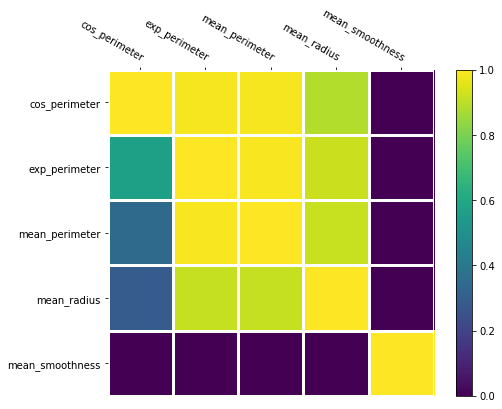

In [ ]:
from src.visualization.utils import heatmap

table = power_score.pivot(columns="x", index="y", values="ppscore")
heatmap(table, row_labels=list(table.index), col_labels=list(table.columns));

## Conclusion

Correlation is a statistical tool that measures the level of relation between two variables.
Multiple formulas exist, with different assumptions about the data distributions.
Equivalent to the mean or the median, pearson and spearman correlations aim at summarising the relation between two variables with only one number.
Exactly like mean or median, this number becomes meaningless when the actual relation is more complex than the assumptions.
More advanced techniques allows to uncover more subtle relation. 
However they also have their own limitations due to their own hypotheses.
In any case, the analyst must keep in mind those limitations and remain critical of the results.

### Exercice

Identify a function `F` such that the Pearson or Spearman correlation between `radius` and `F(radius)` is the closest possible to 0.